# Azure OpenAI Fine-Tuning Tutorial

This notebook provides a comprehensive guide to fine-tuning Azure OpenAI models using the Python SDK. Fine-tuning allows you to customize models to better perform on your specific tasks and datasets.

## What is Fine-Tuning?

Fine-tuning is a process that customizes a pre-trained model by training it on your specific dataset. This provides several benefits:

- **Higher quality results** than prompt engineering alone
- **Ability to train on more examples** than can fit in a prompt
- **Token savings** due to shorter prompts
- **Lower latency** requests

Azure OpenAI uses LoRA (Low Rank Adaptation) for efficient fine-tuning, which reduces complexity while maintaining performance.

## Prerequisites

- Azure OpenAI resource with fine-tuning access
- Cognitive Services OpenAI Contributor role
- Python environment with required packages
- Training data in JSONL format

## 1. Setup and Environment Configuration

In [1]:
import os
import json
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, AzureDeveloperCliCredential, AzureCliCredential
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize Azure credential for Entra ID authentication
# This will try multiple authentication methods in order:
# 1. Environment variables (service principal)
# 2. Managed identity (if running on Azure)
# 3. Azure CLI credential (if logged in via az login)
# 4. Azure Developer CLI credential (if logged in via azd auth login)
try:
    # Try Azure CLI first (most common for development)
    credential = AzureCliCredential()
    print("Using Azure CLI authentication")
except Exception:
    try:
        # Fall back to Azure Developer CLI
        credential = AzureDeveloperCliCredential()
        print("Using Azure Developer CLI authentication")
    except Exception:
        # Fall back to DefaultAzureCredential (tries multiple methods)
        credential = DefaultAzureCredential()
        print("Using DefaultAzureCredential authentication")

# Initialize Azure OpenAI client with Entra ID
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_ad_token_provider=lambda: credential.get_token("https://cognitiveservices.azure.com/.default").token,
    api_version="2024-10-21"  # Required for fine-tuning features
)

print("Azure OpenAI client initialized successfully with Entra ID authentication!")

Using Azure CLI authentication
Azure OpenAI client initialized successfully with Entra ID authentication!


## 2. Data Preparation

Fine-tuning data must be in JSONL format with conversational structure. Each line contains a `messages` array with `role` and `content` fields.

### Required Format:
```json
{"messages": [{"role": "system", "content": "..."}, {"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]}
```

### Best Practices:
- Minimum 10 examples (recommended 50+ for good results)
- Hundreds or thousands of examples for optimal performance
- High-quality, diverse examples
- Consistent system messages
- UTF-8 encoding with BOM
- File size under 512 MB

In [2]:
# Create sample training data for a sarcastic chatbot
training_data = [
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "Who discovered Antarctica?"},
        {"role": "assistant", "content": "Some chaps named Fabian Gottlieb von Bellingshausen and Mikhail Lazarev, as if they don't teach that in every school!"}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What is the biggest ocean?"},
        {"role": "assistant", "content": "The Pacific Ocean. It's not like it's a small pond or anything."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What is the largest planet?"},
        {"role": "assistant", "content": "It's called Jupiter, you might have heard of it...or not."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "Who painted the Mona Lisa?"},
        {"role": "assistant", "content": "Oh, some obscure artist named Leonardo da Vinci. Not that he is famous or anything."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What's the boiling point of water?"},
        {"role": "assistant", "content": "Exciting fact of the day: it's 100 degrees Celsius. Life-changing, isn't it?"}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "Who wrote 'The Odyssey'?"},
        {"role": "assistant", "content": "Oh, just some poet named Homer. Nothing special, really."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What is the largest mammal?"},
        {"role": "assistant", "content": "Blue Whale. Quite a big fish isn't it? Oh wait, it's not a fish!"}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What's the highest mountain peak?"},
        {"role": "assistant", "content": "Everest. Brace yourself, it's not a walk in the park."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "Who invented the telephone?"},
        {"role": "assistant", "content": "A guy named Alexander Graham Bell. Bet you didn't guess that one!"}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What is the distance from Earth to the Sun?"},
        {"role": "assistant", "content": "About 93 million miles. Just a quick drive, really."}
    ]}
]

# Create validation data (smaller subset)
validation_data = [
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "What's the capital of France?"},
        {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}
    ]},
    {"messages": [
        {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
        {"role": "user", "content": "How many continents are there?"},
        {"role": "assistant", "content": "Seven. Shocking revelation, I know."}
    ]}
]

print(f"Created {len(training_data)} training examples")
print(f"Created {len(validation_data)} validation examples")

Created 10 training examples
Created 2 validation examples


In [3]:
# Save data to JSONL files
def save_jsonl(data, filename):
    """Save data to JSONL format with UTF-8 encoding and BOM"""
    with open(filename, 'w', encoding='utf-8-sig') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')
    print(f"Saved {len(data)} examples to {filename}")

# Save training and validation files
training_file_name = 'data/training_set_sarcastic.jsonl'
validation_file_name = 'data/validation_set_sarcastic.jsonl'

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

save_jsonl(training_data, training_file_name)
save_jsonl(validation_data, validation_file_name)

Saved 10 examples to data/training_set_sarcastic.jsonl
Saved 2 examples to data/validation_set_sarcastic.jsonl


In [4]:
# Validate the JSONL format
def validate_jsonl(filename):
    """Validate JSONL file format and structure"""
    print(f"Validating {filename}...")
    
    with open(filename, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()
    
    print(f"Total lines: {len(lines)}")
    
    for i, line in enumerate(lines[:3]):  # Check first 3 lines
        try:
            data = json.loads(line)
            print(f"Line {i+1}: Valid JSON")
            print(f"  Messages: {len(data.get('messages', []))}")
            print(f"  Roles: {[msg['role'] for msg in data.get('messages', [])]}")
        except json.JSONDecodeError as e:
            print(f"Line {i+1}: Invalid JSON - {e}")
    
    print("Validation complete!\n")

validate_jsonl(training_file_name)
validate_jsonl(validation_file_name)

Validating data/training_set_sarcastic.jsonl...
Total lines: 10
Line 1: Valid JSON
  Messages: 3
  Roles: ['system', 'user', 'assistant']
Line 2: Valid JSON
  Messages: 3
  Roles: ['system', 'user', 'assistant']
Line 3: Valid JSON
  Messages: 3
  Roles: ['system', 'user', 'assistant']
Validation complete!

Validating data/validation_set_sarcastic.jsonl...
Total lines: 2
Line 1: Valid JSON
  Messages: 3
  Roles: ['system', 'user', 'assistant']
Line 2: Valid JSON
  Messages: 3
  Roles: ['system', 'user', 'assistant']
Validation complete!



## 3. Upload Training Data

Before starting fine-tuning, we need to upload our training and validation data to Azure OpenAI.

In [5]:
# Upload training data
print("Uploading training data...")
training_response = client.files.create(
    file=open(training_file_name, "rb"),
    purpose="fine-tune"
)
training_file_id = training_response.id
print(f"Training file uploaded: {training_file_id}")

# Upload validation data
print("Uploading validation data...")
validation_response = client.files.create(
    file=open(validation_file_name, "rb"),
    purpose="fine-tune"
)
validation_file_id = validation_response.id
print(f"Validation file uploaded: {validation_file_id}")

print("\nFile upload completed!")

Uploading training data...
Training file uploaded: file-3663f0d967e2408face1c62bb1876059
Uploading validation data...
Validation file uploaded: file-3670e3b5479e48db9b6946c6ca7ebfbd

File upload completed!


In [6]:
# Verify file upload status
def check_file_status(file_id, file_type):
    """Check the status of an uploaded file"""
    try:
        file_info = client.files.retrieve(file_id)
        print(f"{file_type} File Status:")
        print(f"  ID: {file_info.id}")
        print(f"  Filename: {file_info.filename}")
        print(f"  Status: {file_info.status}")
        print(f"  Size: {file_info.bytes} bytes")
        print(f"  Purpose: {file_info.purpose}")
        print()
        return file_info.status == "processed"
    except Exception as e:
        print(f"Error checking {file_type} file: {e}")
        return False

# Check both files
training_ready = check_file_status(training_file_id, "Training")
validation_ready = check_file_status(validation_file_id, "Validation")

if training_ready and validation_ready:
    print("✅ Both files are ready for fine-tuning!")
else:
    print("⏳ Files are still processing...")

Training File Status:
  ID: file-3663f0d967e2408face1c62bb1876059
  Filename: training_set_sarcastic.jsonl
  Status: pending
  Size: 2701 bytes
  Purpose: fine-tune

Validation File Status:
  ID: file-3670e3b5479e48db9b6946c6ca7ebfbd
  Filename: validation_set_sarcastic.jsonl
  Status: pending
  Size: 489 bytes
  Purpose: fine-tune

⏳ Files are still processing...


## 4. Create Fine-Tuning Job

Now we'll create a fine-tuning job with our uploaded data. We'll use GPT-4o-mini as the base model.

In [8]:
# Create fine-tuning job
print("Creating fine-tuning job...")
selected_model = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
fine_tune_response = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model=selected_model,
    seed=105,  # For reproducibility
    suffix="sarcastic-bot",  # Helps identify the model
    hyperparameters={
        "n_epochs": 3,  # Number of training epochs
        "batch_size": 1,  # Small batch size for small dataset
        "learning_rate_multiplier": 1.0  # Default learning rate multiplier
    }
)

job_id = fine_tune_response.id
print(f"Fine-tuning job created: {job_id}")
print(f"Status: {fine_tune_response.status}")
print(f"Model: {fine_tune_response.model}")
print(f"Hyperparameters: {fine_tune_response.hyperparameters}")

Creating fine-tuning job...
Fine-tuning job created: ftjob-20819439e50d40549f0cbbfaf025ea00
Status: pending
Model: gpt-4.1-mini-2025-04-14
Hyperparameters: Hyperparameters(batch_size=1, learning_rate_multiplier=1.0, n_epochs=3)


## 5. Monitor Fine-Tuning Progress

Fine-tuning can take several minutes to hours depending on the dataset size and model. We'll monitor the progress.

In [19]:
def check_job_status(job_id):
    """Check the status of a fine-tuning job"""
    try:
        job_info = client.fine_tuning.jobs.retrieve(job_id)
        return job_info
    except Exception as e:
        print(f"Error checking job status: {e}")
        return None

def display_job_status(job_info):
    """Display formatted job status information"""
    if job_info:
        print(f"Job ID: {job_info.id}")
        print(f"Status: {job_info.status}")
        print(f"Model: {job_info.model}")
        print(f"Fine-tuned model: {job_info.fine_tuned_model or 'Not yet available'}")
        print(f"Created at: {job_info.created_at}")
        if job_info.finished_at:
            print(f"Finished at: {job_info.finished_at}")
        if hasattr(job_info, 'estimated_finish'):
            print(f"Estimated finish: {job_info.estimated_finish}")
        print()

# Check initial status
job_status = check_job_status(job_id)
display_job_status(job_status)

Job ID: ftjob-20819439e50d40549f0cbbfaf025ea00
Status: succeeded
Model: gpt-4.1-mini-2025-04-14
Fine-tuned model: gpt-4.1-mini-2025-04-14.ft-20819439e50d40549f0cbbfaf025ea00-sarcastic-bot
Created at: 1755162345
Finished at: 1755165326
Estimated finish: 1755163245



In [20]:
# Monitor job progress (run this cell periodically)
def monitor_fine_tuning(job_id, check_interval=60):
    """Monitor fine-tuning job progress"""
    print(f"Monitoring fine-tuning job: {job_id}")
    print(f"Checking every {check_interval} seconds...\n")
    
    while True:
        job_info = check_job_status(job_id)
        if not job_info:
            break
            
        status = job_info.status
        print(f"Current status: {status}")
        
        if status in ['succeeded', 'failed', 'cancelled']:
            print(f"\n🎉 Job completed with status: {status}")
            if status == 'succeeded':
                print(f"Fine-tuned model: {job_info.fine_tuned_model}")
            display_job_status(job_info)
            break
        
        print(f"Waiting {check_interval} seconds before next check...")
        time.sleep(check_interval)

# Start monitoring (comment out the line below to monitor manually)
# monitor_fine_tuning(job_id, check_interval=30)

# For manual checking, run this instead:
job_status = check_job_status(job_id)
display_job_status(job_status)

Job ID: ftjob-20819439e50d40549f0cbbfaf025ea00
Status: succeeded
Model: gpt-4.1-mini-2025-04-14
Fine-tuned model: gpt-4.1-mini-2025-04-14.ft-20819439e50d40549f0cbbfaf025ea00-sarcastic-bot
Created at: 1755162345
Finished at: 1755165326
Estimated finish: 1755163245



In [18]:
# View fine-tuning events (detailed progress)
def get_fine_tuning_events(job_id, limit=10):
    """Get recent fine-tuning events"""
    try:
        events = client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=limit
        )
        
        print(f"Recent fine-tuning events (last {limit}):")
        print("-" * 60)
        
        for event in events.data:
            timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(event.created_at))
            print(f"[{timestamp}] {event.level}: {event.message}")
        
    except Exception as e:
        print(f"Error retrieving events: {e}")

# Get recent events
get_fine_tuning_events(job_id)

Recent fine-tuning events (last 10):
------------------------------------------------------------
[2025-08-14 12:55:26] info: Training tokens billed: 2000
[2025-08-14 12:55:26] info: Model Evaluation Passed.
[2025-08-14 12:55:26] info: Completed results file: file-30673b7edf0a41b9904a82cc94cbdeea
[2025-08-14 12:55:00] info: Job succeeded.
[2025-08-14 12:35:17] info: Step 30: training loss=0.5673991441726685
[2025-08-14 12:35:07] info: Step 20: training loss=1.184482216835022
[2025-08-14 12:34:57] info: Step 10: training loss=1.766325831413269
[2025-08-14 12:34:48] info: Step 1: training loss=4.3313069343566895
[2025-08-14 12:34:47] info: Created results file: file-30673b7edf0a41b9904a82cc94cbdeea
[2025-08-14 12:26:52] info: Training started.


## 6. Analyze Training Results

Once fine-tuning is complete, we can download and analyze the results to understand model performance.

In [25]:
# Download and analyze results (run after job completion)
def download_results(job_id):
    """Download and analyze fine-tuning results"""
    job_info = check_job_status(job_id)
    
    if job_info.status != 'succeeded':
        print(f"Job status is {job_info.status}. Results not available yet.")
        return None
    
    if not job_info.result_files:
        print("No result files available.")
        return None
    
    # Download the first result file
    result_file_id = job_info.result_files[0]
    print(f"Downloading result file: {result_file_id}")
    
    try:
        # Get file info
        file_info = client.files.retrieve(result_file_id)
        filename = f"results_{job_id}.csv"
        
        # Download file content
        with open(filename, "wb") as file:
            result = client.files.content(result_file_id).read()
            file.write(result)
        
        print(f"Results saved to: {filename}")
        return filename
        
    except Exception as e:
        print(f"Error downloading results: {e}")
        return None

# Download results (uncomment when job is complete)
results_file = download_results(job_id)

Results saved to: results_ftjob-20819439e50d40549f0cbbfaf025ea00.csv


Results Analysis:
Total training steps: 30
Columns: step, train_loss, train_mean_token_accuracy, train_error_rate, valid_loss, valid_mean_token_accuracy, valid_error_rate, full_valid_loss, full_valid_mean_token_accuracy, full_valid_error_rate, timestamp

Summary Statistics:
            step  train_loss  train_mean_token_accuracy  train_error_rate  \
count  30.000000   30.000000                  30.000000               0.0   
mean   15.500000    1.338139                   0.727222               NaN   
std     8.803408    0.944000                   0.149349               NaN   
min     1.000000    0.448082                   0.375000               NaN   
25%     8.250000    0.697150                   0.659375               NaN   
50%    15.500000    1.019094                   0.750000               NaN   
75%    22.750000    1.706374                   0.837500               NaN   
max    30.000000    4.331307                   1.000000               NaN   

       valid_loss  valid_mean_t

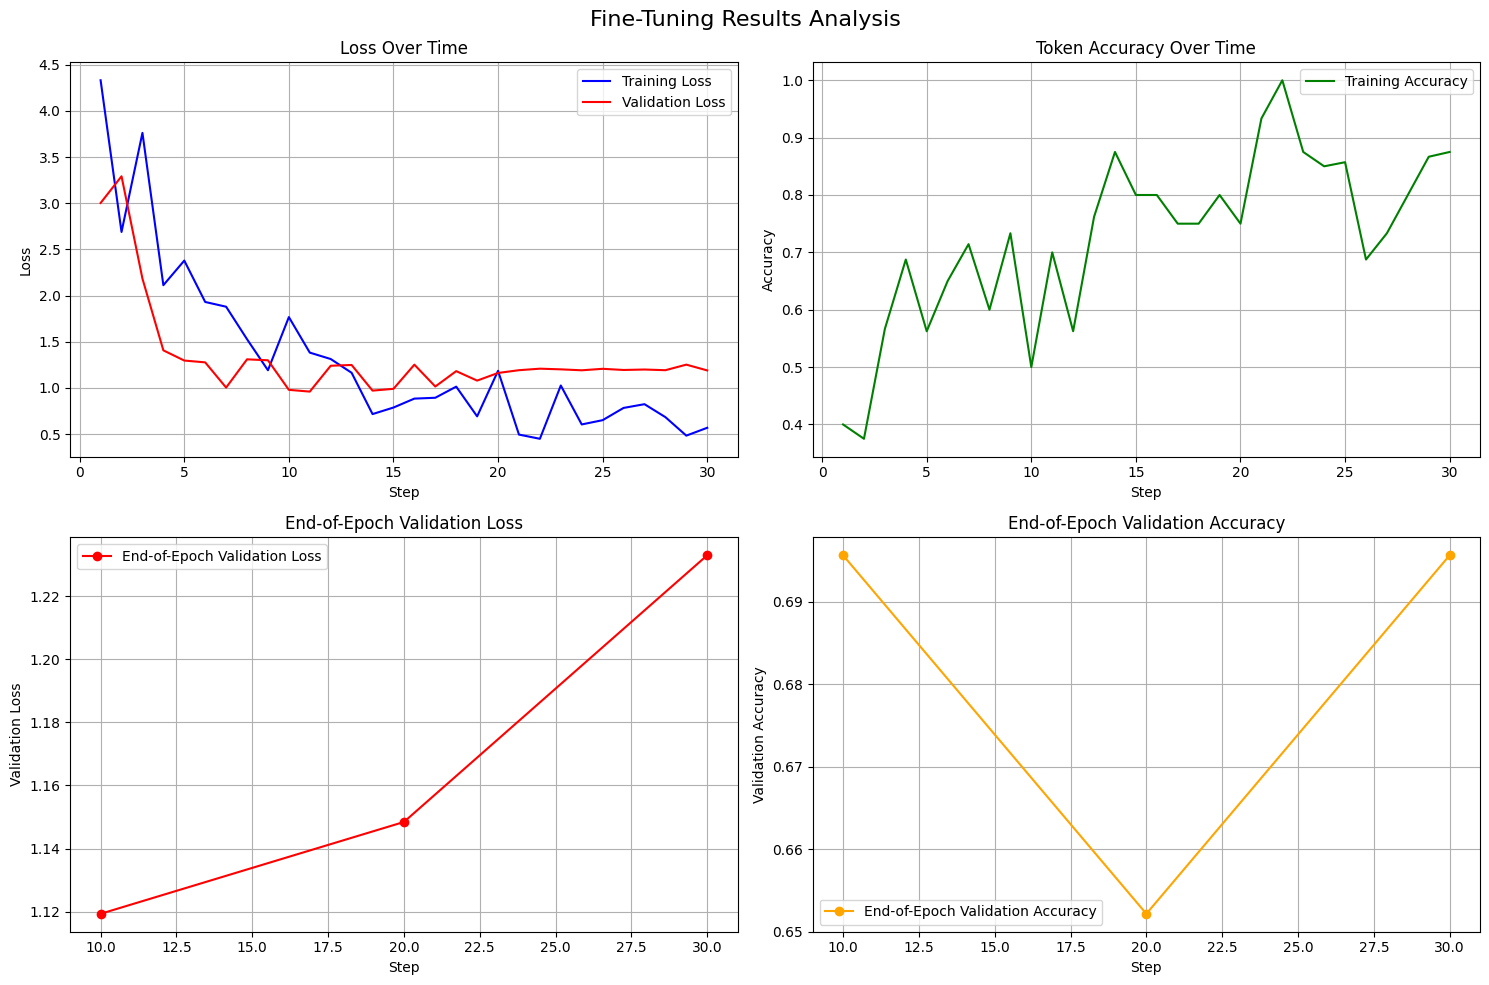


Performance Insights:
------------------------------
Training loss improvement: 86.90%
Training accuracy improvement: +47.50 percentage points
⚠️  Potential overfitting detected (validation loss >> training loss)


In [26]:
# Analyze results with visualization
def analyze_results(results_file):
    """Analyze and visualize fine-tuning results"""
    if not results_file or not os.path.exists(results_file):
        print("Results file not found. Make sure fine-tuning is complete and results are downloaded.")
        return
    
    # Read results
    df = pd.read_csv(results_file)
    print("Results Analysis:")
    print("=" * 50)
    print(f"Total training steps: {len(df)}")
    print(f"Columns: {', '.join(df.columns)}")
    print()
    
    # Display summary statistics
    print("Summary Statistics:")
    print(df.describe())
    print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Fine-Tuning Results Analysis', fontsize=16)
    
    # Training Loss
    if 'train_loss' in df.columns:
        axes[0, 0].plot(df['step'], df['train_loss'], label='Training Loss', color='blue')
        if 'valid_loss' in df.columns:
            axes[0, 0].plot(df['step'], df['valid_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Loss Over Time')
        axes[0, 0].set_xlabel('Step')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
    
    # Token Accuracy
    if 'train_mean_token_accuracy' in df.columns:
        axes[0, 1].plot(df['step'], df['train_mean_token_accuracy'], label='Training Accuracy', color='green')
        if 'validation_mean_token_accuracy' in df.columns:
            axes[0, 1].plot(df['step'], df['validation_mean_token_accuracy'], label='Validation Accuracy', color='orange')
        axes[0, 1].set_title('Token Accuracy Over Time')
        axes[0, 1].set_xlabel('Step')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # Full validation metrics (end of epoch)
    if 'full_valid_loss' in df.columns:
        epoch_data = df[df['full_valid_loss'].notna()]
        if not epoch_data.empty:
            axes[1, 0].plot(epoch_data['step'], epoch_data['full_valid_loss'], 
                           marker='o', label='End-of-Epoch Validation Loss', color='red')
            axes[1, 0].set_title('End-of-Epoch Validation Loss')
            axes[1, 0].set_xlabel('Step')
            axes[1, 0].set_ylabel('Validation Loss')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
    
    if 'full_valid_mean_token_accuracy' in df.columns:
        epoch_data = df[df['full_valid_mean_token_accuracy'].notna()]
        if not epoch_data.empty:
            axes[1, 1].plot(epoch_data['step'], epoch_data['full_valid_mean_token_accuracy'], 
                           marker='o', label='End-of-Epoch Validation Accuracy', color='orange')
            axes[1, 1].set_title('End-of-Epoch Validation Accuracy')
            axes[1, 1].set_xlabel('Step')
            axes[1, 1].set_ylabel('Validation Accuracy')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Performance insights
    print("\nPerformance Insights:")
    print("-" * 30)
    
    if 'train_loss' in df.columns:
        initial_loss = df['train_loss'].iloc[0]
        final_loss = df['train_loss'].iloc[-1]
        loss_improvement = (initial_loss - final_loss) / initial_loss * 100
        print(f"Training loss improvement: {loss_improvement:.2f}%")
    
    if 'train_mean_token_accuracy' in df.columns:
        initial_acc = df['train_mean_token_accuracy'].iloc[0]
        final_acc = df['train_mean_token_accuracy'].iloc[-1]
        acc_improvement = (final_acc - initial_acc) * 100
        print(f"Training accuracy improvement: +{acc_improvement:.2f} percentage points")
    
    # Check for overfitting
    if 'train_loss' in df.columns and 'valid_loss' in df.columns:
        final_train_loss = df['train_loss'].iloc[-1]
        final_valid_loss = df['valid_loss'].iloc[-1]
        
        if final_valid_loss > final_train_loss * 1.2:
            print("⚠️  Potential overfitting detected (validation loss >> training loss)")
        else:
            print("✅ No significant overfitting detected")

# Analyze results (uncomment when results are available)
analyze_results(results_file)

## 7. Deploy Fine-Tuned Model

Once fine-tuning is complete, we need to deploy the model to use it for inference.

In [16]:
# Get fine-tuned model ID
def get_fine_tuned_model_id(job_id):
    """Get the fine-tuned model ID from completed job"""
    job_info = check_job_status(job_id)
    
    if job_info.status == 'succeeded':
        return job_info.fine_tuned_model
    else:
        print(f"Job status: {job_info.status}. Model not ready for deployment.")
        return None

# Get the model ID (uncomment when job is complete)
# fine_tuned_model_id = get_fine_tuned_model_id(job_id)
# print(f"Fine-tuned model ID: {fine_tuned_model_id}")

# For demo purposes, we'll use a placeholder
fine_tuned_model_id = "gpt-4o-mini-2024-07-18.ft-example123.sarcastic-bot"
print(f"Model ID (example): {fine_tuned_model_id}")

Model ID (example): gpt-4o-mini-2024-07-18.ft-example123.sarcastic-bot


In [17]:
# Deploy the fine-tuned model
# Note: This requires management API access and differs from the data plane API

def deploy_fine_tuned_model(model_id, deployment_name):
    """
    Deploy a fine-tuned model using Azure Management API
    This is a simplified example - in practice, you'll need proper authentication
    """
    print("To deploy your fine-tuned model, you have several options:")
    print()
    print("1. Azure Portal:")
    print("   - Go to Azure AI Foundry (https://ai.azure.com)")
    print("   - Navigate to Deployments")
    print("   - Click 'Deploy model'")
    print(f"   - Select your fine-tuned model: {model_id}")
    print(f"   - Give it a deployment name: {deployment_name}")
    print()
    print("2. Azure CLI:")
    print(f"   az cognitiveservices account deployment create \\")
    print(f"     --resource-group <your-resource-group> \\")
    print(f"     --account-name <your-openai-resource> \\")
    print(f"     --deployment-name {deployment_name} \\")
    print(f"     --model-name '{model_id}' \\")
    print(f"     --model-version '1' \\")
    print(f"     --model-format OpenAI \\")
    print(f"     --sku-capacity 1 \\")
    print(f"     --sku-name 'Standard'")
    print()
    print("3. Management REST API (see deployment section in notebook)")

deployment_name = "sarcastic-chatbot-deployment"
deploy_fine_tuned_model(fine_tuned_model_id, deployment_name)

To deploy your fine-tuned model, you have several options:

1. Azure Portal:
   - Go to Azure AI Foundry (https://ai.azure.com)
   - Navigate to Deployments
   - Click 'Deploy model'
   - Select your fine-tuned model: gpt-4o-mini-2024-07-18.ft-example123.sarcastic-bot
   - Give it a deployment name: sarcastic-chatbot-deployment

2. Azure CLI:
   az cognitiveservices account deployment create \
     --resource-group <your-resource-group> \
     --account-name <your-openai-resource> \
     --deployment-name sarcastic-chatbot-deployment \
     --model-name 'gpt-4o-mini-2024-07-18.ft-example123.sarcastic-bot' \
     --model-version '1' \
     --model-format OpenAI \
     --sku-capacity 1 \
     --sku-name 'Standard'

3. Management REST API (see deployment section in notebook)


## 8. Test Fine-Tuned Model

Once deployed, we can test our fine-tuned model to see how it performs.

In [ ]:
# Test the fine-tuned model (uncomment when deployed)
def test_fine_tuned_model(deployment_name_fine_tuned, test_messages):
    """
    Test the fine-tuned model with sample messages
    """
    
    try:
        response = client.chat.completions.create(
            model=deployment_name_fine_tuned,
            messages=test_messages,
            temperature=0.7,
            max_tokens=150
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        print(f"Error testing model: {e}")
        return None

# Test cases
test_cases = [
    {
        "messages": [
            {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
            {"role": "user", "content": "What's the capital of Italy?"}
        ],
        "description": "Geography question"
    },
    {
        "messages": [
            {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
            {"role": "user", "content": "How many days are in a week?"}
        ],
        "description": "Basic knowledge question"
    },
    {
        "messages": [
            {"role": "system", "content": "Clippy is a factual chatbot that is also sarcastic."},
            {"role": "user", "content": "Who was the first person on the moon?"}
        ],
        "description": "Historical question"
    }
]

print("Test Cases for Fine-Tuned Model:")
print("=" * 50)

for i, test_case in enumerate(test_cases, 1):
    print(f"\nTest {i}: {test_case['description']}")
    print(f"User: {test_case['messages'][1]['content']}")
    
    # Uncomment the line below when model is deployed
    deployment_name_fine_tuned = "add here"
    response = test_fine_tuned_model(deployment_name_fine_tuned, test_case['messages'])
    print(f"Assistant: {response}")
    
    # Placeholder response for demo
    print(f"Assistant: [Response from fine-tuned model would appear here]")
    print("-" * 40)

Test Cases for Fine-Tuned Model:

Test 1: Geography question
User: What's the capital of Italy?
Assistant: Oh, just a little place called Rome. You might have heard of it.
Assistant: [Response from fine-tuned model would appear here]
----------------------------------------

Test 2: Basic knowledge question
User: How many days are in a week?
Assistant: Seven days. Not a lot, but enough to make you realize weekends are too short.
Assistant: [Response from fine-tuned model would appear here]
----------------------------------------

Test 3: Historical question
User: Who was the first person on the moon?
Assistant: Neil Armstrong. Not that he had a choice, really.
Assistant: [Response from fine-tuned model would appear here]
----------------------------------------


## 9. Continuous Fine-Tuning

You can further fine-tune an already fine-tuned model with additional data.

In [ ]:
# Continuous fine-tuning example
def create_continuous_fine_tuning_job(base_fine_tuned_model, new_training_file_id, new_validation_file_id=None):
    """
    Create a fine-tuning job using an already fine-tuned model as the base
    """
    print(f"Creating continuous fine-tuning job...")
    print(f"Base model: {base_fine_tuned_model}")
    
    try:
        response = client.fine_tuning.jobs.create(
            training_file=new_training_file_id,
            validation_file=new_validation_file_id,
            model=base_fine_tuned_model,  # Use the fine-tuned model as base
            suffix="v2",  # Version identifier
            hyperparameters={
                "n_epochs": 2,  # Fewer epochs for continuous training
                "learning_rate_multiplier": 0.1  # Lower learning rate
            }
        )
        
        print(f"Continuous fine-tuning job created: {response.id}")
        return response.id
        
    except Exception as e:
        print(f"Error creating continuous fine-tuning job: {e}")
        return None

# Example of how to use continuous fine-tuning
print("Continuous Fine-Tuning Process:")
print("1. Prepare additional training data")
print("2. Upload new training files")
print("3. Use the fine-tuned model ID as the base model")
print("4. Create new fine-tuning job")
print("5. Monitor and deploy the improved model")
print()
print("Benefits:")
print("- Iterative improvement")
print("- Incorporate new data/feedback")
print("- Refine model behavior")
print("- Adapt to changing requirements")

## 10. Best Practices and Tips

Here are important best practices for successful fine-tuning:

In [ ]:
# Best practices summary
best_practices = {
    "Data Quality": [
        "Use high-quality, diverse examples",
        "Ensure consistent formatting",
        "Include edge cases and variations",
        "Remove low-quality or contradictory examples",
        "Use the same system message throughout"
    ],
    "Dataset Size": [
        "Minimum 10 examples (not recommended for production)",
        "50+ examples for basic fine-tuning",
        "Hundreds to thousands for best results",
        "Quality over quantity",
        "Consider data augmentation for small datasets"
    ],
    "Hyperparameters": [
        "Start with default settings",
        "Lower learning rates prevent overfitting",
        "Larger batch sizes for larger datasets",
        "Monitor training/validation loss divergence",
        "Use checkpoints to prevent overfitting"
    ],
    "Monitoring": [
        "Watch for decreasing loss over time",
        "Monitor token accuracy improvements",
        "Check for overfitting (validation >> training loss)",
        "Use early stopping if needed",
        "Analyze results.csv file"
    ],
    "Deployment": [
        "Test with Developer deployment first",
        "Use same system message as training",
        "Monitor inference performance",
        "Consider cost implications",
        "Plan for model lifecycle management"
    ],
    "Cost Optimization": [
        "Use Global training tier if no data residency requirements",
        "Delete inactive deployments (auto-deleted after 15 days)",
        "Consider model size vs. performance trade-offs",
        "Monitor training costs",
        "Use checkpoints to avoid retraining"
    ]
}

print("🎯 Fine-Tuning Best Practices")
print("=" * 50)

for category, practices in best_practices.items():
    print(f"\n📋 {category}:")
    for practice in practices:
        print(f"   • {practice}")

print("\n" + "=" * 50)
print("Remember: Fine-tuning is iterative. Start simple, measure results, and improve gradually!")

## 11. Cleanup and Resource Management

In [ ]:
# Cleanup functions
def list_uploaded_files():
    """List all uploaded files"""
    try:
        files = client.files.list()
        print("Uploaded Files:")
        print("-" * 40)
        
        for file in files.data:
            print(f"ID: {file.id}")
            print(f"Name: {file.filename}")
            print(f"Purpose: {file.purpose}")
            print(f"Size: {file.bytes} bytes")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error listing files: {e}")

def delete_file(file_id):
    """Delete an uploaded file"""
    try:
        client.files.delete(file_id)
        print(f"Deleted file: {file_id}")
    except Exception as e:
        print(f"Error deleting file {file_id}: {e}")

def list_fine_tuning_jobs():
    """List all fine-tuning jobs"""
    try:
        jobs = client.fine_tuning.jobs.list()
        print("Fine-tuning Jobs:")
        print("-" * 40)
        
        for job in jobs.data:
            print(f"ID: {job.id}")
            print(f"Status: {job.status}")
            print(f"Model: {job.model}")
            print(f"Fine-tuned Model: {job.fine_tuned_model or 'N/A'}")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error listing jobs: {e}")

# Resource management info
print("🧹 Resource Management")
print("=" * 30)
print()
print("Important Notes:")
print("• Deployments are auto-deleted after 15 days of inactivity")
print("• Deployed models incur hourly hosting costs")
print("• Training files can be deleted after fine-tuning")
print("• Fine-tuned models can be stored at no cost until deployed")
print()
print("Use the functions above to manage your resources:")
print("• list_uploaded_files() - See all uploaded files")
print("• delete_file(file_id) - Delete specific files")
print("• list_fine_tuning_jobs() - See all fine-tuning jobs")

# Uncomment to run cleanup functions
# list_uploaded_files()
# list_fine_tuning_jobs()

## Summary

This notebook covered the complete fine-tuning workflow for Azure OpenAI:

1. **Setup**: Environment configuration and client initialization
2. **Data Preparation**: Creating and formatting training data in JSONL format
3. **Upload**: Uploading training and validation files to Azure OpenAI
4. **Training**: Creating and monitoring fine-tuning jobs
5. **Analysis**: Downloading and analyzing training results
6. **Deployment**: Deploying the fine-tuned model for inference
7. **Testing**: Validating model performance with test cases
8. **Continuous Improvement**: Iterative fine-tuning processes
9. **Best Practices**: Guidelines for successful fine-tuning
10. **Cleanup**: Resource management and cost optimization

### Next Steps:
- Prepare your own training data
- Experiment with different hyperparameters
- Monitor model performance in production
- Iterate and improve based on user feedback

### Resources:
- [Azure OpenAI Fine-tuning Documentation](https://learn.microsoft.com/en-us/azure/ai-foundry/openai/how-to/fine-tuning)
- [Model Availability and Regional Support](https://learn.microsoft.com/en-us/azure/ai-foundry/openai/concepts/models#fine-tuning-models)
- [Azure OpenAI Pricing](https://azure.microsoft.com/pricing/details/cognitive-services/openai-service/)
- [Fine-tuning Best Practices](https://learn.microsoft.com/en-us/azure/ai-foundry/openai/concepts/fine-tuning-considerations)